# Итоговый проект "Банки — Анализ оттока клиентов"

Ссылка на презентацию: <a src='https://disk.yandex.ru/d/G9JcgyG8YoXPMg'>https://disk.yandex.ru/d/G9JcgyG8YoXPMg</a>

### Задача:

Проанализируйте клиентов регионального банка и выделите сегменты клиентов, которые склонны уходить из банка.

- Провести исследовательский анализ данных,
- Выделить портреты клиентов, которые склонны уходить из банка,
- Сформулировать и проверьте статистические гипотезы
- Подвести промежуточный итог о том, какие показатели стратегически влияют на отток
- Сделать выводы и рекомендации (конкретные, по конкретным сегментам) для заказчика

    *Проверьте гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались.*

    *Сформулируйте и проверьте статистическую гипотезу относительно представленных данных*


(задачи выше сформулированы предварительно, окончательная постановка задачи произойдёт на вводной встрече)

### Описание датасетов

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `equity` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Last_activity` — активный клиент,
- `est_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

По итогам исследования подготовьте презентацию. Для создания презентации используйте любой удобный инструмент, но отправить презентацию нужно **обязательно** в формате **pdf,** прикрепив ссылку на файл в основном проекте.

In [637]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.weightstats
from scipy import stats as st
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## Шаг 1. Загрузка данных и подготовка к исследованию

In [638]:
server_path = 'datasets/'
local_path = '/datasets/'

files = ['bank_dataset.csv', 'bank_scrooge.csv']

datasets = []

for file in files:
    try:
        datasets.append(pd.read_csv(server_path + file))
    except FileNotFoundError:
        datasets.append(pd.read_csv(local_path + file))

df_old = datasets[0]

path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F"
df_new = datasets[1]

In [639]:
df = df_new
df.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34,5,174.00,1,1,0,67353.16,1


In [640]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            10000 non-null  int64  
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB


Вывод: из данных видно, что есть пропуски в столбце: balance. Столбцы приведены к правильным типам данных.

## Шаг 2. Подготовка данных (анализ пропусков) и их кодирование

### 2.1 Привести название столбцов к строчному регистру

In [641]:
df.columns = [i.lower() for i in df.columns]
df.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34,5,174.00,1,1,0,67353.16,1


### 2.2 Проверить на пропуски данных и решить что с пропусками делать

In [642]:
df['balance'].head()

0      59214.82
1     850594.33
2           NaN
3    1524746.26
4        174.00
Name: balance, dtype: float64

In [643]:
len(df[df['balance'].isna()])

2295

In [644]:
len(df[df['balance'].isna()])/len(df)

0.2295

Вывод: из полученных данных видим, что пропуски в столбце составляют 23%

In [645]:
df[df['balance'].isna() == True].head(10)

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
9,133130,906.0,Ярославль,Ж,67,0,NaN,1,0,1,238055.53,0
10,148929,927.0,Ростов,М,52,0,NaN,1,1,1,196820.07,0
11,172184,921.0,Ростов,М,41,0,NaN,1,1,1,217469.48,0
19,127034,922.0,Рыбинск,Ж,53,0,NaN,1,0,0,147094.82,0
21,177415,896.0,Рыбинск,Ж,47,0,NaN,1,0,0,225060.35,0
30,155730,946.0,Ярославль,Ж,47,0,NaN,2,1,1,660015.85,0
34,205226,944.0,Ярославль,М,35,0,NaN,2,1,1,239843.39,0
39,173175,924.0,Рыбинск,Ж,51,0,NaN,1,1,1,248844.47,0
43,228585,956.0,Ростов,М,41,0,NaN,1,1,0,115117.10,0


In [646]:
len(df[(df['balance'].isna() == True) & (df['churn'] == 1)])

13

In [647]:
len(df[(df['balance'].isna() == True) & (df['churn'] == 0)])

2282

In [648]:
len(df[df['balance'] == 0])

2

In [649]:
len(df[(df['balance'].isna() == True) & (df['credit_card'] == 1)])

1872

In [650]:
len(df[(df['balance'].isna() == True) & (df['credit_card'] == 0)])

423

In [651]:
len(df[(df['balance'].isna() == True) & (df['credit_card'] == 0)])/ len(df)

0.0423

Вывод: из данных видно, что почти все клиенты с пропусками остаются клиентами банка (только 13 человек ушли). Стоит отметить, что если посмотреть кол-во клиентов со значением на балансе 0, то можно увидеть, что таких всего 2. Можно предположить что пропуски вызваны тем, что клиненты не имеют средств на счете (возможно даже не пополняли), такое может быть если допустим карты раздавалить и оформлялись на клиентов качетсве промоакции. Клиентов с кредитнами картами оказалось подовляющее большинство из данной когорты. Пропуски клиентов без кредитных карт составляют всего 4%. Данные пропуски относятся к группе MNAR. Значение NaN относиться к типу float и можно не менять данное значение на 0.

### 2.3 добавить столбец наличие заработной карты (если зарплата больше 0, то заработная карта есть, иначе - нет)

In [652]:
df[df['est_salary'] > 0].head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34,5,174.00,1,1,0,67353.16,1


In [653]:
len(df[df['est_salary'] > 0])

10000

Вывод: на основе полученных данных видно, что у всех в бд указана зарплата, скорее всего тут указана зарплата на основании информации клиентов или банка о их зарплата, не зависимо является клиент пользователем зарплаьного проекта в данном банке. На основе данным нельзя определить принадлежность клиента к зарплатному проекту в банке.

## Шаг 3. Исследовательский анализ данных (распределения, в т.ч. в разрезе оттока; портреты клиентов и их сравнение; корреляционный анализ)

### 3.1 Распределения, в т.ч. в разрезе оттока; портреты клиентов и их сравнение

проверить как влияет Возраст/баллы кредитного скоринга/заработная плата клиента на: кол-во объектов недвижимости, баланс счете, кол-во продуктов которыми пользуется клиент, наличие кредитной карты

In [654]:
df.corr()

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
userid,1.000000,0.009804,0.017890,0.004599,0.006133,-0.005683,0.005674,-0.031029,-0.000369,-0.012398
score,0.009804,1.000000,-0.012164,0.064126,0.235812,-0.004981,-0.094732,-0.031179,0.163866,0.106129
age,0.017890,-0.012164,1.000000,0.032934,0.071599,0.031810,-0.131441,-0.004164,-0.043305,-0.055798
equity,0.004599,0.064126,0.032934,1.000000,0.164126,0.430203,-0.167506,-0.001970,-0.171974,0.270672
balance,0.006133,0.235812,0.071599,0.164126,1.000000,0.073024,-0.059253,0.025004,0.339622,0.085442
products,-0.005683,-0.004981,0.031810,0.430203,0.073024,1.000000,-0.256392,0.040071,-0.119738,0.297110
credit_card,0.005674,-0.094732,-0.131441,-0.167506,-0.059253,-0.256392,1.000000,-0.033445,0.035556,-0.131491
last_activity,-0.031029,-0.031179,-0.004164,-0.001970,0.025004,0.040071,-0.033445,1.000000,0.003039,0.169190
est_salary,-0.000369,0.163866,-0.043305,-0.171974,0.339622,-0.119738,0.035556,0.003039,1.000000,0.001128
churn,-0.012398,0.106129,-0.055798,0.270672,0.085442,0.297110,-0.131491,0.169190,0.001128,1.000000


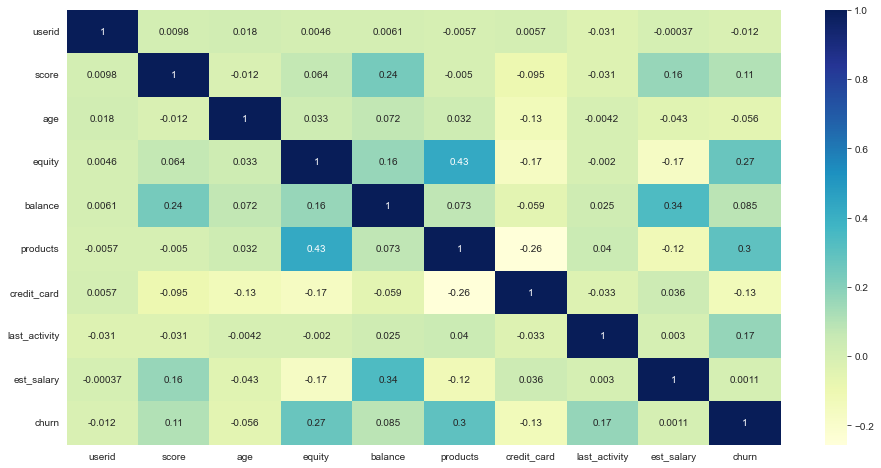

In [655]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

Вывод: из полученных данных видно, что взаимосвясь присутвует только в:
- кол-во продуктов и кол-во объектов недвижимости
- кол-во кредитного скоринга и уровнем дохода

Для того чтобы лучше выделить парамметры, которые влияют на отток клиентов, воспользуемся модулем phik.

In [656]:
!pip install phik

In [657]:
import phik

In [658]:
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['userid', 'score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn']
interval columns not set, guessing: ['userid', 'score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn']


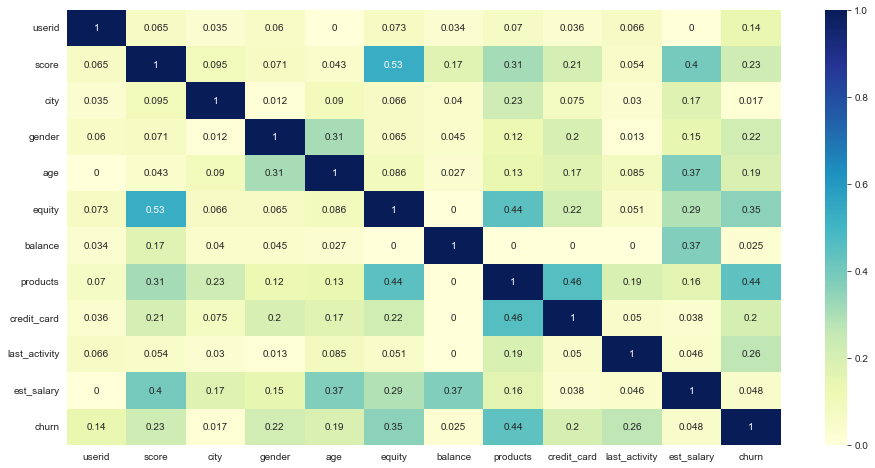

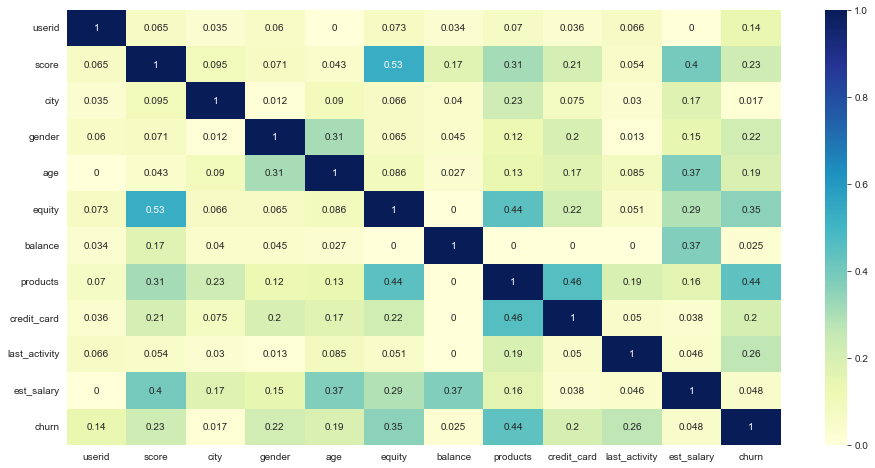

In [659]:
plt.figure(figsize=(16, 8))
sns.heatmap(phik_overview, cmap="YlGnBu", annot=True)
plt.show()

In [660]:
phik_overview['churn'].sort_values(ascending=False)

churn            1.000000
products         0.440106
equity           0.352883
last_activity    0.261815
score            0.228322
gender           0.218275
credit_card      0.204077
age              0.189179
userid           0.139757
est_salary       0.047778
balance          0.024634
city             0.016762
Name: churn, dtype: float64

churn            1.000000
products         0.440106
equity           0.352883
last_activity    0.261815
score            0.228322
gender           0.218275
credit_card      0.204077
age              0.189179
userid           0.139757
est_salary       0.047778
balance          0.024634
city             0.016762
Name: churn, dtype: float64

Вывод: как видим из полученных данных видно, что наибольшее воздействие на отток клиентов оказывают: product, equity. Так же видно, что немалое воздействие оказывают: last_activity, score, gender, credit_cart, age.
Далее рассмотрим их подробнее.

### Модель классификации
Построим модель классификации и сравним с нашими первыми выводами

In [661]:
!pip install catboost

In [662]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from catboost import Pool

In [663]:
df_ml = df.copy()
df_ml['balance'] = df_ml['balance'].fillna(0)
df_ml.isnull().count()

userid           10000
score            10000
city             10000
gender           10000
age              10000
equity           10000
balance          10000
products         10000
credit_card      10000
last_activity    10000
est_salary       10000
churn            10000
dtype: int64

userid           10000
score            10000
city             10000
gender           10000
age              10000
equity           10000
balance          10000
products         10000
credit_card      10000
last_activity    10000
est_salary       10000
churn            10000
dtype: int64

In [664]:
train, test = train_test_split(df_ml, train_size=0.6, random_state=0, stratify=df['churn'])
val, test = train_test_split(test, train_size=0.5, random_state=0, stratify=test['churn'])

In [665]:
train.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

Index(['userid', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

In [666]:
X = ['score', 'city', 'gender', 'age', 'equity', 'balance',
     'products', 'credit_card', 'last_activity', 'est_salary']
cat_features = ['city', 'gender', 'credit_card', 'last_activity']
y = ['churn']

In [667]:
train_data = Pool(
    data=train[X],
    label=train[y],
    cat_features=cat_features
                  )
valid_data = Pool(
    data=val[X],
    label=val[y],
    cat_features=cat_features
)

In [668]:
params = {
    'verbose': 100,
    'random_seed': 0,
    'learning_rate': .01
}

In [669]:
model = CatBoostClassifier(**params)
model.fit(train_data, eval_set=valid_data)

0:	learn: 0.6860781	test: 0.6861506	best: 0.6861506 (0)	total: 8.12ms	remaining: 8.11s
100:	learn: 0.3712151	test: 0.3699129	best: 0.3699129 (100)	total: 384ms	remaining: 3.42s
200:	learn: 0.3179498	test: 0.3214894	best: 0.3214894 (200)	total: 820ms	remaining: 3.26s
300:	learn: 0.2947499	test: 0.3030843	best: 0.3030843 (300)	total: 1.22s	remaining: 2.84s
400:	learn: 0.2824406	test: 0.2949297	best: 0.2949297 (400)	total: 1.61s	remaining: 2.4s
500:	learn: 0.2741838	test: 0.2900401	best: 0.2900401 (500)	total: 1.91s	remaining: 1.91s
600:	learn: 0.2668168	test: 0.2855262	best: 0.2855262 (600)	total: 2.23s	remaining: 1.48s
700:	learn: 0.2596759	test: 0.2824135	best: 0.2824135 (700)	total: 2.54s	remaining: 1.08s
800:	learn: 0.2535738	test: 0.2803376	best: 0.2803376 (800)	total: 2.85s	remaining: 707ms
900:	learn: 0.2474602	test: 0.2781622	best: 0.2781488 (899)	total: 3.17s	remaining: 348ms
999:	learn: 0.2413941	test: 0.2771201	best: 0.2771201 (999)	total: 3.5s	remaining: 0us

bestTest = 0.277

0:	learn: 0.6860781	test: 0.6861506	best: 0.6861506 (0)	total: 6.04ms	remaining: 6.04s
100:	learn: 0.3712151	test: 0.3699129	best: 0.3699129 (100)	total: 408ms	remaining: 3.63s
200:	learn: 0.3179498	test: 0.3214894	best: 0.3214894 (200)	total: 945ms	remaining: 3.75s
300:	learn: 0.2947499	test: 0.3030843	best: 0.3030843 (300)	total: 1.58s	remaining: 3.68s
400:	learn: 0.2824406	test: 0.2949297	best: 0.2949297 (400)	total: 1.95s	remaining: 2.91s
500:	learn: 0.2741838	test: 0.2900401	best: 0.2900401 (500)	total: 2.27s	remaining: 2.26s
600:	learn: 0.2668168	test: 0.2855262	best: 0.2855262 (600)	total: 2.6s	remaining: 1.73s
700:	learn: 0.2596759	test: 0.2824135	best: 0.2824135 (700)	total: 2.91s	remaining: 1.24s
800:	learn: 0.2535738	test: 0.2803376	best: 0.2803376 (800)	total: 3.23s	remaining: 803ms
900:	learn: 0.2474602	test: 0.2781622	best: 0.2781488 (899)	total: 3.56s	remaining: 392ms
999:	learn: 0.2413941	test: 0.2771201	best: 0.2771201 (999)	total: 3.91s	remaining: 0us

bestTest = 0.27

In [670]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,balance,19.564812
1,score,17.298975
2,age,13.340174
3,last_activity,12.968920
4,products,7.924716
5,gender,7.801508
6,equity,6.823510
7,est_salary,5.666556
8,city,4.773353
9,credit_card,3.837477


,Feature Id,Importances
0,balance,19.564812
1,score,17.298975
2,age,13.340174
3,last_activity,12.968920
4,products,7.924716
5,gender,7.801508
6,equity,6.823510
7,est_salary,5.666556
8,city,4.773353
9,credit_card,3.837477


In [671]:
phik_overview_train = train.phik_matrix()
phik_overview_train['churn'].sort_values(ascending=False)

interval columns not set, guessing: ['userid', 'score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn']


churn            1.000000
products         0.435429
equity           0.354305
last_activity    0.276223
score            0.224954
gender           0.217586
credit_card      0.200181
age              0.181517
userid           0.148589
est_salary       0.037119
balance          0.035772
city             0.011751
Name: churn, dtype: float64

interval columns not set, guessing: ['userid', 'score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn']


churn            1.000000
products         0.435429
equity           0.354305
last_activity    0.276223
score            0.224954
gender           0.217586
credit_card      0.200181
age              0.181517
userid           0.148589
est_salary       0.037119
balance          0.035772
city             0.011751
Name: churn, dtype: float64

Вывод по разделу:
- анализ phik позволил выделить следующие важные параметры: product, equity, last_activity, score, gender, credit_cart, age
- модель машинного бучения выделила следующие важные параметры: balance, score, age.
Далее рассмотрим все параметры подробнее и выдвинем гипотезы.

## 3.2 Выделите портреты клиентов, которые склонны уходить из банка

### Как влияет на отток кол-во продуктов, которыми пользуется клиент

In [672]:
df.groupby('products')['churn'].agg(['count', 'mean']) 

,count,mean
products,,
0,1,1.000000
1,3341,0.070338
2,5108,0.191660
3,1046,0.284895
4,474,0.632911
5,30,0.300000


,count,mean
products,,
0,1,1.000000
1,3341,0.070338
2,5108,0.191660
3,1046,0.284895
4,474,0.632911
5,30,0.300000


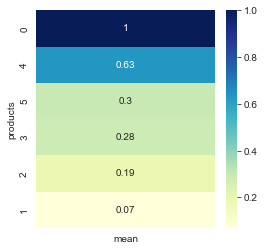

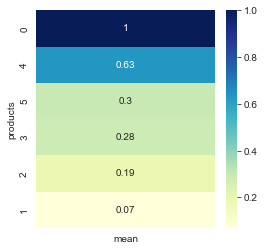

In [673]:
plt.figure(figsize=(4, 4))
sns.heatmap(df.groupby('products')['churn'].agg(['mean']).sort_values(by='mean', ascending=False), cmap="YlGnBu", annot=True)
plt.show()

Вывод:
- из полученных данных мы видим тенденцию к увеличению оттока при увеличении числа продуктов, но стоит отметить что в выборку где больше 3-х продуктов попало малая доля клиентов.
- меньше всего уходят клиенты, которые пользуются одним продуктом.

### Как влияет кол-во объектов собственности на отток клиентов

In [674]:
df.groupby('equity')['churn'].agg(['count', 'mean'])

,count,mean
equity,,
0,2592,0.034722
1,774,0.120155
2,1052,0.157795
3,1543,0.209332
4,1850,0.251351
5,1918,0.300834
6,161,0.360248
7,80,0.462500
8,17,0.352941


,count,mean
equity,,
0,2592,0.034722
1,774,0.120155
2,1052,0.157795
3,1543,0.209332
4,1850,0.251351
5,1918,0.300834
6,161,0.360248
7,80,0.462500
8,17,0.352941


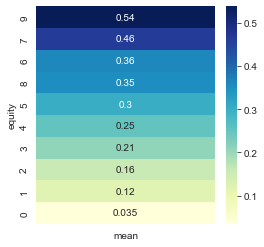

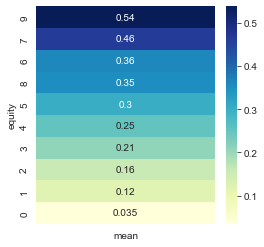

In [675]:
plt.figure(figsize=(4, 4))
sns.heatmap(df.groupby('equity')['churn'].agg(['mean']).sort_values(by='mean', ascending=False), cmap="YlGnBu", annot=True)
plt.show()

Вывод:
- мы так же можем заметить тенденцию по увеличению оттока при увеличении кол-во объектов в собственности, но стоит заметить что клиентов с увеличением становиться заметно меньше и это нормально т.к. кол-во людей с большим количеством собственности всегда будет заметно меньше подавляющего большинства.
- практически не уходят клиенты, которые не имеют объектов недвижимости.

### Влияние активности клиентов на отток

In [676]:
df.groupby('last_activity')['churn'].agg(['count', 'mean'])

,count,mean
last_activity,,
0,4765,0.113746
1,5235,0.244508


,count,mean
last_activity,,
0,4765,0.113746
1,5235,0.244508


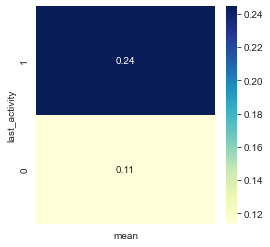

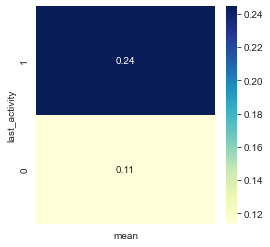

In [677]:
plt.figure(figsize=(4, 4))
sns.heatmap(df.groupby('last_activity')['churn'].agg(['mean']).sort_values(by='mean', ascending=False), cmap="YlGnBu", annot=True)
plt.show()

Вывод:
- как мы можем видеть активные клиенты в два раза чаще уходят из данного банка
- не активные в два раза чаще остаются

### Влияние баллов score на отток

In [678]:
df['score_cut'] = pd.qcut(df['score'], 3)
df['score_cut'].head()

0      (819.0, 886.0]
1      (819.0, 886.0]
2     (886.0, 1000.0]
3      (819.0, 886.0]
4    (641.999, 819.0]
Name: score_cut, dtype: category
Categories (3, interval[float64, right]): [(641.999, 819.0] < (819.0, 886.0] < (886.0, 1000.0]]

0      (819.0, 886.0]
1      (819.0, 886.0]
2     (886.0, 1000.0]
3      (819.0, 886.0]
4    (641.999, 819.0]
Name: score_cut, dtype: category
Categories (3, interval[float64, right]): [(641.999, 819.0] < (819.0, 886.0] < (886.0, 1000.0]]

In [679]:
df.groupby('score_cut')['churn'].agg(['count', 'mean'])

,count,mean
score_cut,,
"(641.999, 819.0]",3357,0.107239
"(819.0, 886.0]",3347,0.251569
"(886.0, 1000.0]",3296,0.188107


,count,mean
score_cut,,
"(641.999, 819.0]",3357,0.107239
"(819.0, 886.0]",3347,0.251569
"(886.0, 1000.0]",3296,0.188107


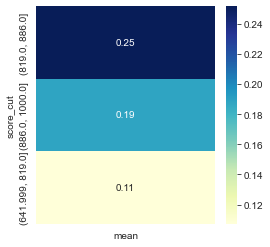

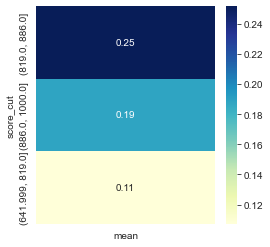

In [680]:
plt.figure(figsize=(4, 4))
sns.heatmap(df.groupby('score_cut')['churn'].agg(['mean']).sort_values(by='mean', ascending=False), cmap="YlGnBu", annot=True)
plt.show()

Вывод:
- из данных видно, у которых балл больше 820, в два раза больше склонны к оттоку. Стоит отметить что самое большое кол-во клиентов уходит в диапазоне от 820 до 886.
- меньше всего уходят клиент с наименьшими баллами.

### Как влияет пол на отток клиентов

In [681]:
df.groupby('gender')['churn'].agg(['count', 'mean'])

,count,mean
gender,,
Ж,4992,0.127804
М,5008,0.236422


,count,mean
gender,,
Ж,4992,0.127804
М,5008,0.236422


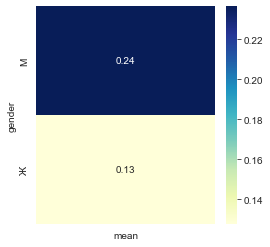

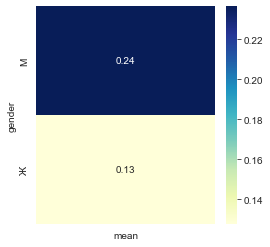

In [682]:
plt.figure(figsize=(4, 4))
sns.heatmap(df.groupby('gender')['churn'].agg(['mean']).sort_values(by='mean', ascending=False), cmap="YlGnBu", annot=True)
plt.show()

Вывод:
- из полученных данных видно, что мужчины чаще склонны к оттоку
- женщины реже уходят

### Влияние наличия кредитной карты на отток

In [683]:
df.groupby('credit_card')['churn'].agg(['count', 'mean'])

,count,mean
credit_card,,
0,3196,0.256258
1,6804,0.147413


,count,mean
credit_card,,
0,3196,0.256258
1,6804,0.147413


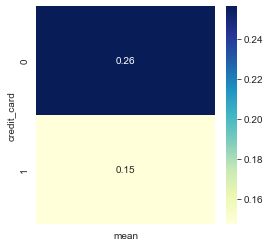

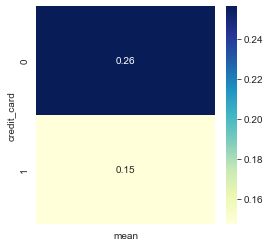

In [684]:
plt.figure(figsize=(4, 4))
sns.heatmap(df.groupby('credit_card')['churn'].agg(['mean']).sort_values(by='mean', ascending=False), cmap="YlGnBu", annot=True)
plt.show()

Вывод:
- клиенты без кредитных карт намного чаще уходят, чем клиенты пользующиеся кредитками
- клиентами с кредитками чаще остаются

### Влияние возраста на отток

In [685]:
df['age_cut'] = pd.qcut(df['age'], 6)
df['age_cut'].head()

0    (17.999, 31.0]
1      (36.0, 40.0]
2    (17.999, 31.0]
3      (47.0, 56.0]
4      (31.0, 36.0]
Name: age_cut, dtype: category
Categories (6, interval[float64, right]): [(17.999, 31.0] < (31.0, 36.0] < (36.0, 40.0] < (40.0, 47.0] < (47.0, 56.0] < (56.0, 86.0]]

0    (17.999, 31.0]
1      (36.0, 40.0]
2    (17.999, 31.0]
3      (47.0, 56.0]
4      (31.0, 36.0]
Name: age_cut, dtype: category
Categories (6, interval[float64, right]): [(17.999, 31.0] < (31.0, 36.0] < (36.0, 40.0] < (40.0, 47.0] < (47.0, 56.0] < (56.0, 86.0]]

In [686]:
df.groupby('age_cut')['churn'].agg(['count', 'mean'])

,count,mean
age_cut,,
"(17.999, 31.0]",1682,0.221760
"(31.0, 36.0]",2000,0.190000
"(36.0, 40.0]",1425,0.171930
"(40.0, 47.0]",1718,0.137369
"(47.0, 56.0]",1509,0.241882
"(56.0, 86.0]",1666,0.133854


,count,mean
age_cut,,
"(17.999, 31.0]",1682,0.221760
"(31.0, 36.0]",2000,0.190000
"(36.0, 40.0]",1425,0.171930
"(40.0, 47.0]",1718,0.137369
"(47.0, 56.0]",1509,0.241882
"(56.0, 86.0]",1666,0.133854


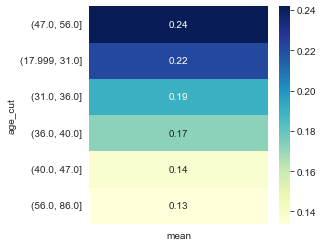

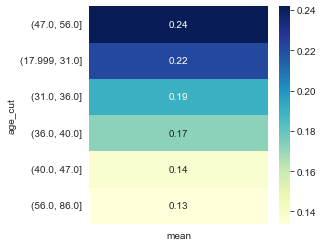

In [687]:
plt.figure(figsize=(4, 4))
sns.heatmap(df.groupby('age_cut')['churn'].agg(['mean']).sort_values(by='mean', ascending=False), cmap="YlGnBu", annot=True)
plt.show()

Вывод:
- из полученных данных видно, что клиенты до 31 года чаще уходят из банка. Виден сильный скачок в возрастном промежутке 47-56 лет
- клиенты старшего возраста реже уходят, но сильно выраженной тенденции нет

### Влияние баланса на счете на отток

In [688]:
df['balance_cut'] = pd.qcut(df['balance'], 5)

In [689]:
df.groupby('balance_cut')['churn'].agg(['count', 'mean'])

,count,mean
balance_cut,,
"(-0.001, 255936.848]",1541,0.156392
"(255936.848, 419603.476]",1541,0.169371
"(419603.476, 660138.374]",1541,0.189487
"(660138.374, 1125547.2]",1541,0.242051
"(1125547.2, 119113552.01]",1541,0.416613


,count,mean
balance_cut,,
"(-0.001, 255936.848]",1541,0.156392
"(255936.848, 419603.476]",1541,0.169371
"(419603.476, 660138.374]",1541,0.189487
"(660138.374, 1125547.2]",1541,0.242051
"(1125547.2, 119113552.01]",1541,0.416613


Вывод:
- стоит отметить что клиенты с заметно большим балансом на счете чаще уходят других. В остальных группах заметна так же небольшая тенденция к росту оттока
- клиенты с меньшим достатком склонны к оттоку.

### Рассмотрим, как влияют парамметры на модель в нашей получившейся модели

In [690]:
!pip install shap

In [691]:
import shap

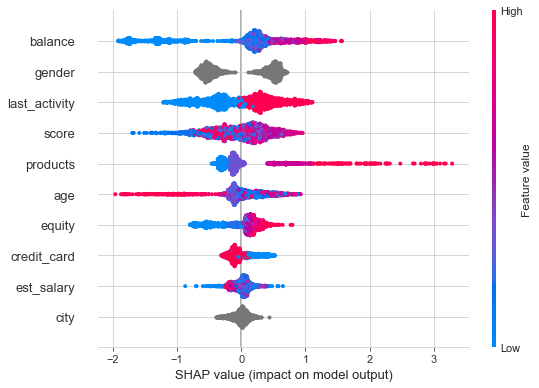

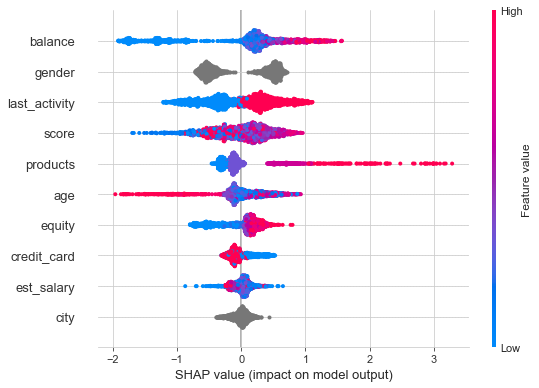

In [692]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[X])
shap.summary_plot(shap_values, test[X])

Рассмотрим переменные подробнее

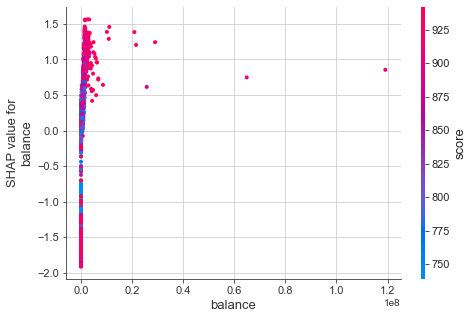

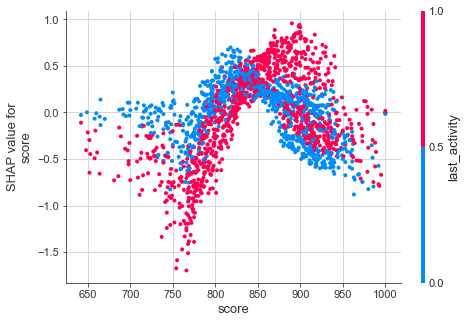

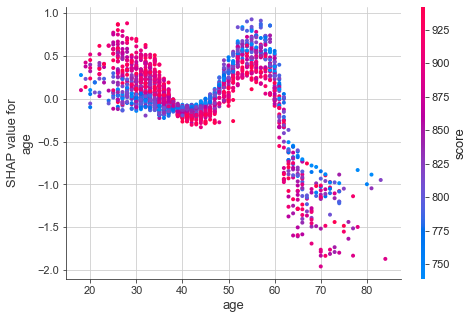

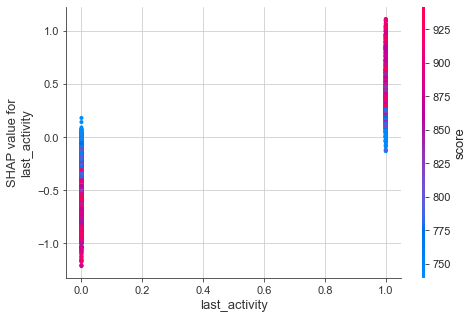

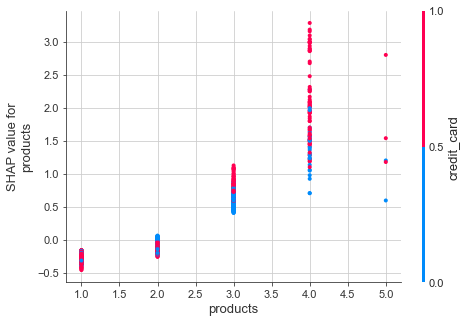

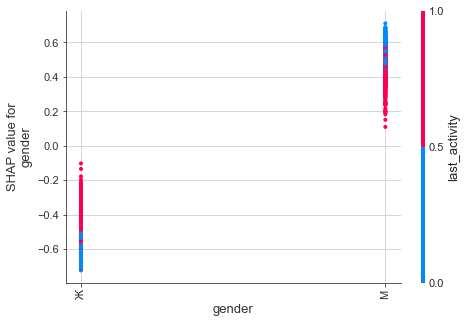

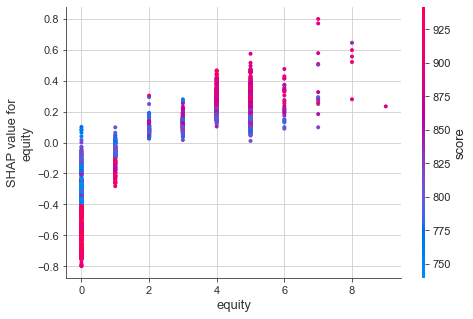

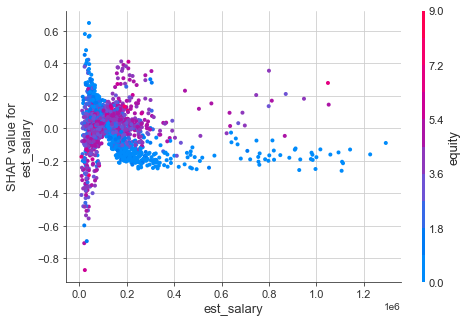

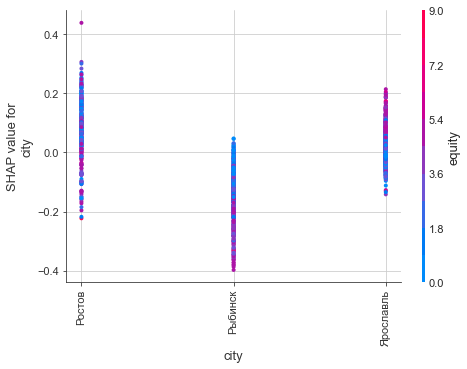

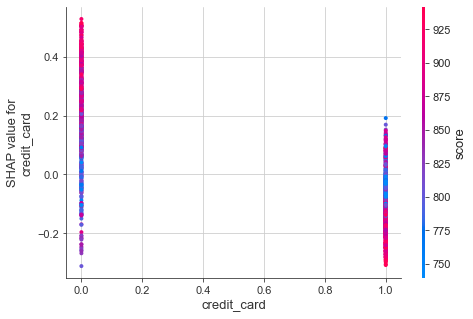

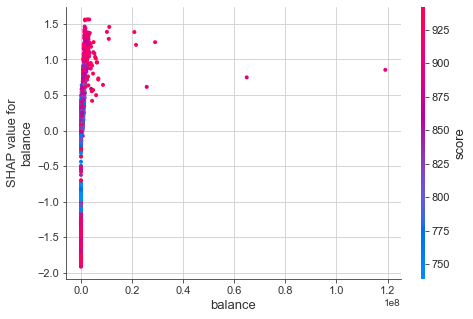

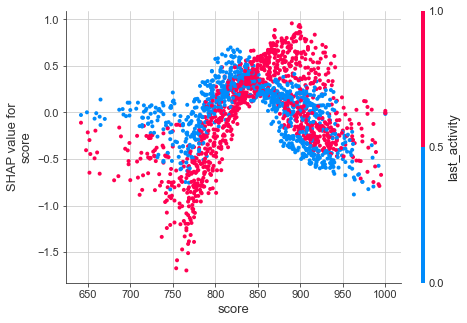

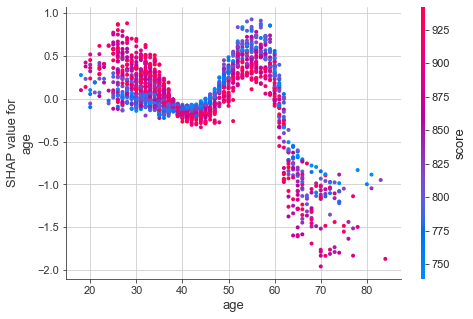

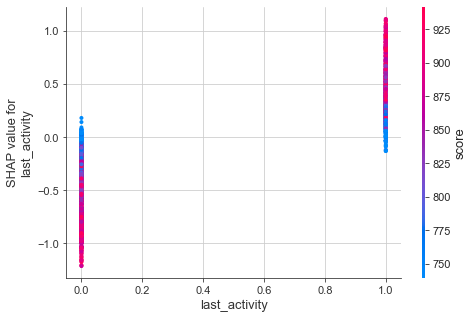

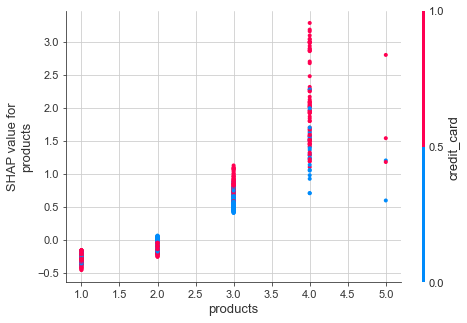

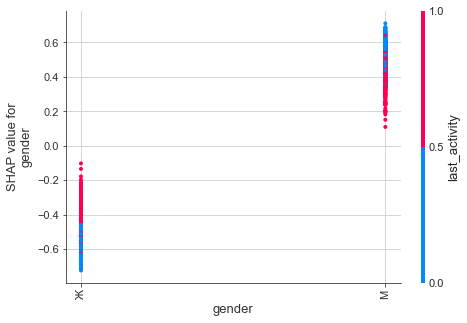

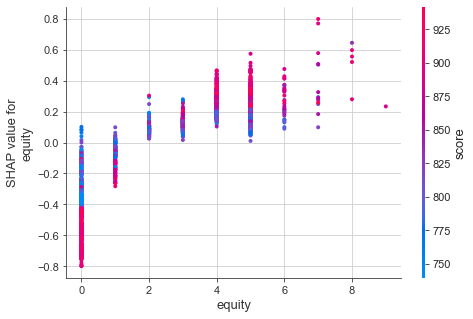

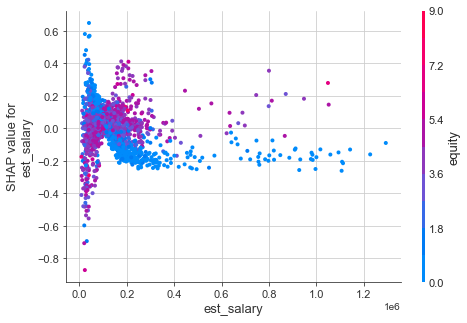

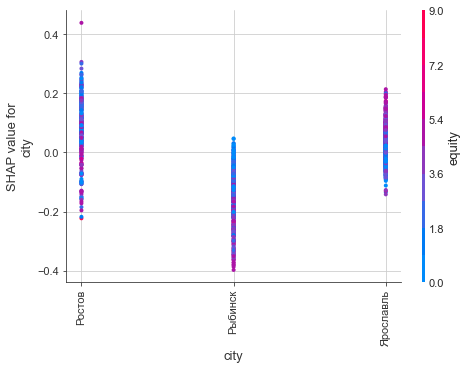

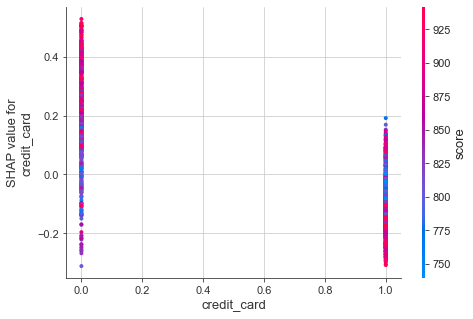

In [693]:
for i in model.get_feature_importance(prettified=True)['Feature Id'].values:
    shap.dependence_plot(i, shap_values, test[X])

Вывод:
- чем больше баланс на счет, тем больше клиент больше склонен к оттоку
- чем больше активность пользователя, чем больше склонен к оттоку
- пользователи, которые пользуются большим кол-м продуктов, склонны к оттоку
- чем ниже возраст клиента, тем больше он склонен к оттоку
- чем больше объектов в собственнсти, тем выше отток

<b>Общий вывод по разделу:</b>

Вывод по разделу построю по описанию двух портретов клиентов склонных к оттоку/не склонных.

<b>Результаты на основе phik</b>
<b>Клиенты склонные к оттоку:</b>
- являются пользователями больше 3-х банковских продуктов
- если имеют больше 1-го объектов в собственности
- являются активными пользователями банка
- имеют балл score больше 820
- чаще всего являются мужчинами
- не имеют кредитных карт
- возраст до 31 года
- имеют большие суммы на балансе счета.

<b>Клиенты не склонные к оттоку:</b>
- пользуются одним банковским продуктом
- не имеют объектов недвижимости в собственности
- не являются активными пользователями банковских услуг
- имеют наимеший балл score
- чаще всего являются женщинами
- имеют кредитные карты
- старше 31-го года
- имеют малые суммы на счетах банка.

<b>Результаты на основе модели построенной в CatBoost</b>
<b>Клиенты склонные к оттоку:</b>
- являются пользователями большим кол-м банковских продуктов
- имеют в собственности объекты
- являются активными пользователями банка
- имеют большой балл score
- имеют меньший возраст
- имеют большие суммы на балансе счета.

<b>Клиенты не склонные к оттоку:</b>
- пользуются меньшим кол-м банковских продуктов
- имеют мало объектов недвижимости в собственности
- не являются активными пользователями банковских услуг
- имеют кредитные карты
- являются возрастными
- имеют малые суммы на счетах банка.

Проанализируем и соединим воедино получившиеся портреты:

<b>Клиенты склонные к оттоку:</b>
- являются пользователями больше 3-х банковских продуктов
- если имеют объекты в собственности
- являются активными пользователями банка
- имеют балл score больше 820
- чаще всего являются мужчинами
- не имеют кредитных карт
- возраст до 31 года
- имеют большие суммы на балансе счета.

<b>Клиенты не склонные к оттоку:</b>
- пользуются одним банковским продуктом
- не имеют объекты недвижимости в собственности
- не являются активными пользователями банковских услуг
- имеют наимеший балл score
- чаще всего являются женщинами
- имеют кредитные карты
- старше 31-го года
- имеют малые суммы на счетах банка.

## Шаг 5. Проверка статистических гипотез
Проверим гипотезы:
- различия дохода между теми клиентами, которые ушли и теми, которые остались
- различие кол-ва объектов в собствености между пользователями которые ушли и которые остались
- различие кол-ва баллов кредитного score между пользователями которые ушли и которые остались
- различие в возрасте между пользователями которые ушли и которые остались

### Различия дохода между теми клиентами, которые ушли и теми, которые остались

Сформулируем две гипотезы:
H0: нет различия дохода между клиентами которые ушли и клиентами которые остались
H1: есть различие дохода между клиентами которые ушли и клиентами которые остались

In [694]:
df_salary_0 = df[df['churn'] == 0]['est_salary'].sample(n=70)
df_salary_1 = df[df['churn'] == 1]['est_salary'].sample(n=70)

<AxesSubplot:>

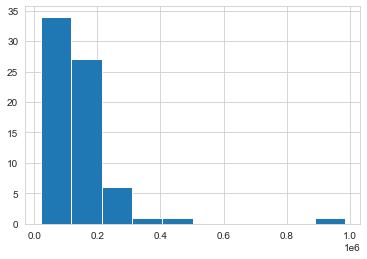

<AxesSubplot:>

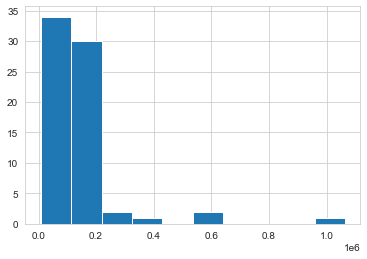

In [695]:
df_salary_0.hist()

<AxesSubplot:>

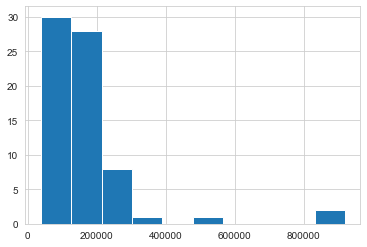

<AxesSubplot:>

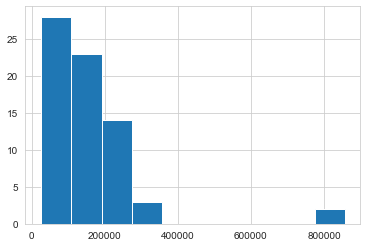

In [696]:
df_salary_1.hist()

In [697]:
alpha = .05 # пороговое значение возьмем за 5%

results = st.ttest_ind(
    df_salary_0,
    df_salary_1)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.32653337738238175
Не получилось отвергнуть нулевую гипотезу
p-значение: 0.6142909831284855
Не получилось отвергнуть нулевую гипотезу


Вывод: нет различия дохода между клиентами которые ушли и клиентами которые остались

### Различие кол-ва баллов кредитного score между пользователями которые ушли и которые остались
Сформулируем две гипотезы:
H0: нет различия кол-ва баллов кредитного score между клиентами которые ушли и клиентами которые остались
H1: есть различие кол-ва баллов кредитного score между клиентами которые ушли и клиентами которые остались


In [698]:
df_score_0 = df[df['churn'] == 0]['score'].sample(n=70)
df_score_1 = df[df['churn'] == 1]['score'].sample(n=70)

<AxesSubplot:>

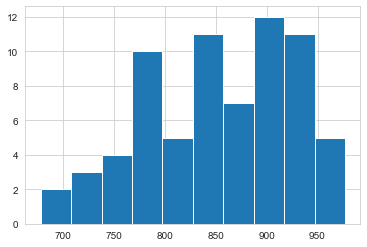

<AxesSubplot:>

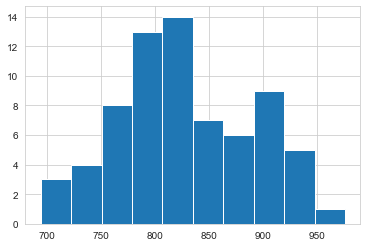

In [699]:
df_score_0.hist()

<AxesSubplot:>

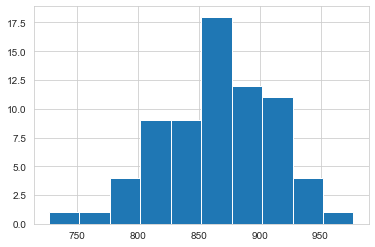

<AxesSubplot:>

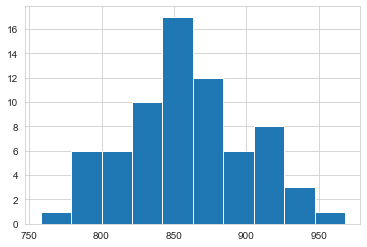

In [700]:
df_score_1.hist()

In [701]:
alpha = .05 # пороговое значение возьмем за 5%

results = st.ttest_ind(
    df_score_0,
    df_score_1)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.29062669891335374
Не получилось отвергнуть нулевую гипотезу
p-значение: 0.0023722057614928064
Отвергаем нулевую гипотезу


Вывод: нет различия кол-ва баллов кредитного score между клиентами которые ушли и клиентами которые остались

## Шаг 6. Промежуточный итог о том, какие показатели стратегически влияют на отток.
В ходе исследования подтвердились следующие гипотезы:
- нет различия дохода между клиентами, которые ушли и клиентами которые остались
- нет различия кол-ва баллов кредитного score между клиентами которые ушли и клиентами которые остались

и получились следующие портреты клиентов:

<b>Клиенты склонные к оттоку:</b>
- являются пользователями больше 3-х банковских продуктов
- если имеют объекты в собственности
- являются активными пользователями банка
- чаще всего являются мужчинами
- не имеют кредитных карт
- возраст до 31 года
- имеют большие суммы на балансе счета.

<b>Клиенты не склонные к оттоку:</b>
- пользуются одним банковским продуктом
- не имеют объекты недвижимости в собственности
- не являются активными пользователями банковских услуг
- чаще всего являются женщинами
- имеют кредитные карты
- старше 31-го года
- имеют малые суммы на счетах банка.


## Шаг 7. Сегментация на основе стратегических показателей.

churn
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: products, dtype: object

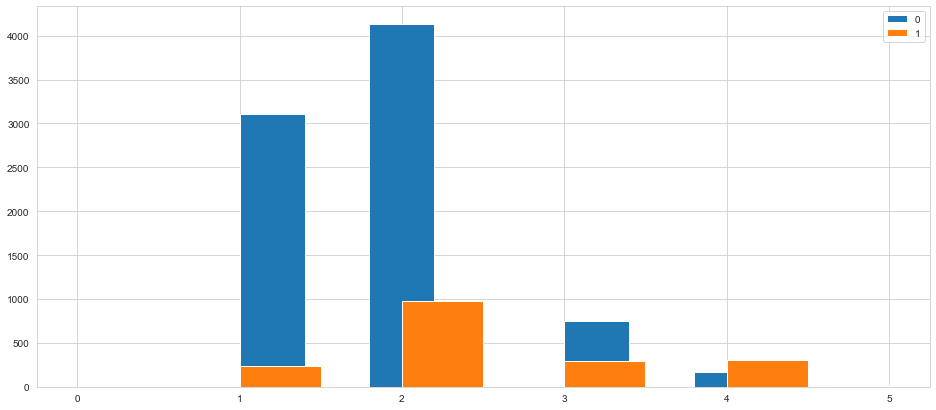

churn
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: products, dtype: object

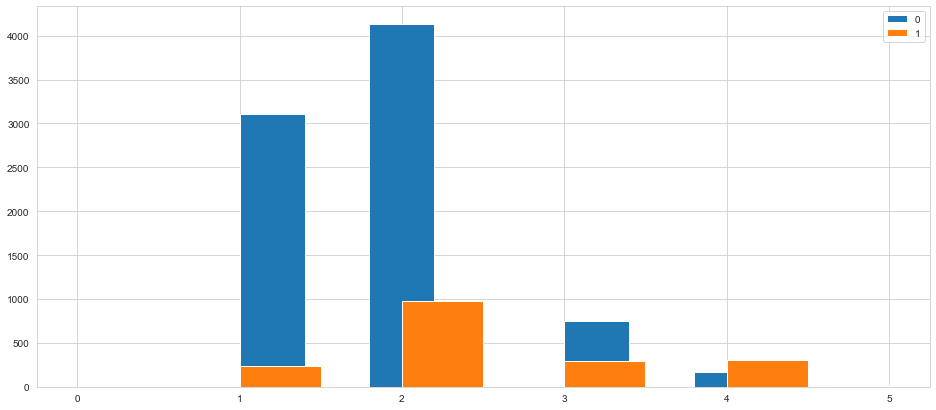

In [702]:
df.groupby('churn')['products'].hist(figsize=(16, 7), legend=True)

Вывод: как видно пользователей можно разделить на три сегмента: один продукт, два продукта и свыше 3-х продуктов

churn
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: equity, dtype: object

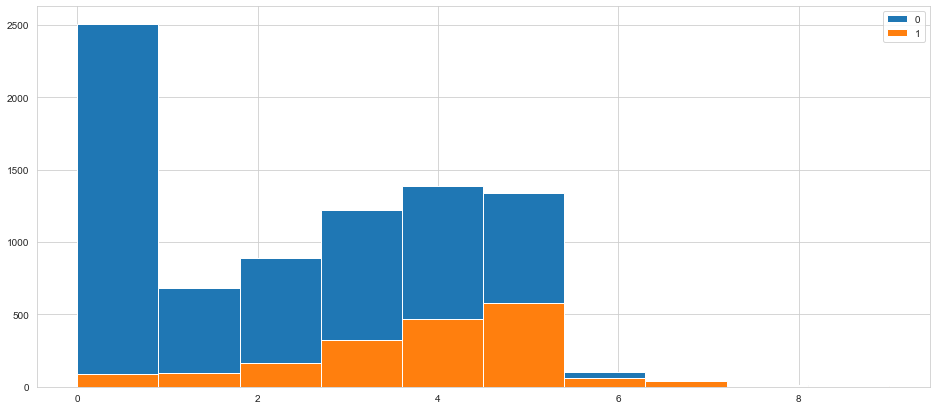

churn
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: equity, dtype: object

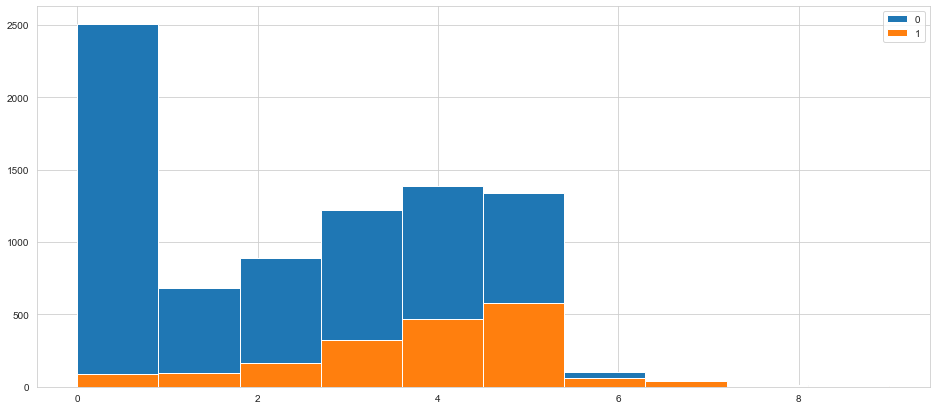

In [703]:
df.groupby('churn')['equity'].hist(figsize=(16, 7), legend=True)

Вывод: как видим пользователей можно разделить: до 3-х объектов недвижимости, более 3-х до 5-ти и свыше 5-ти.

churn
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: score, dtype: object

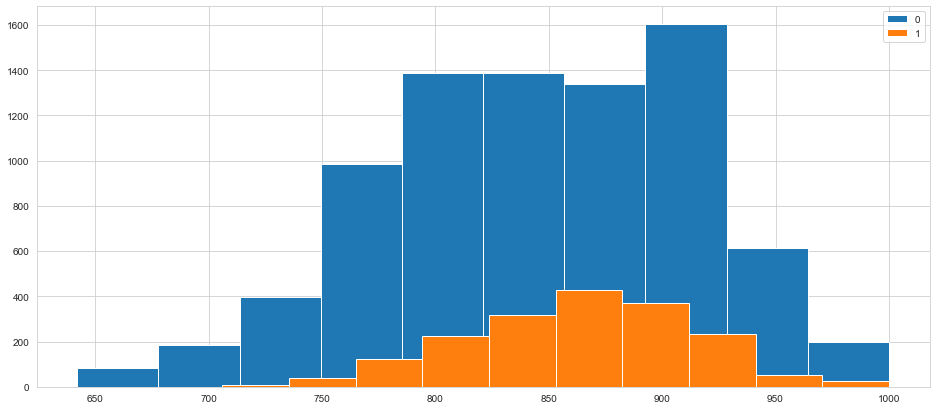

churn
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: score, dtype: object

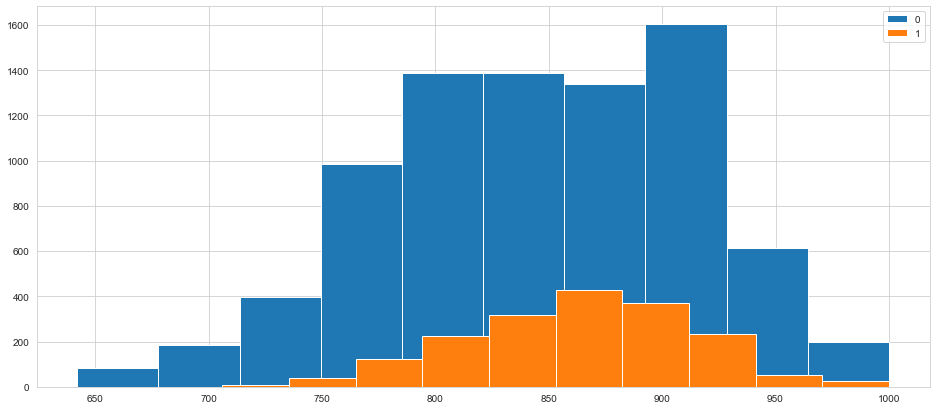

In [704]:
df.groupby('churn')['score'].hist(figsize=(16, 7), legend=True)

Вывод: Пользователей можно разделить на следующие сегменты по уровню кредитного рейтинга: до 850, от 850 до 920 и свыше 920

churn
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

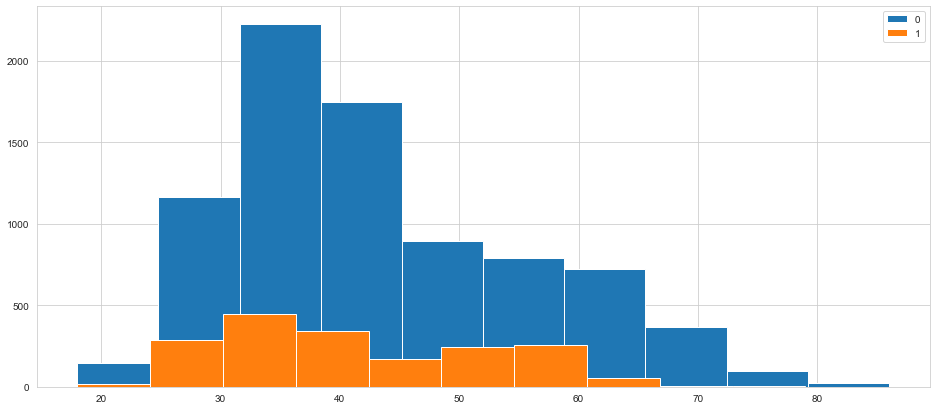

churn
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

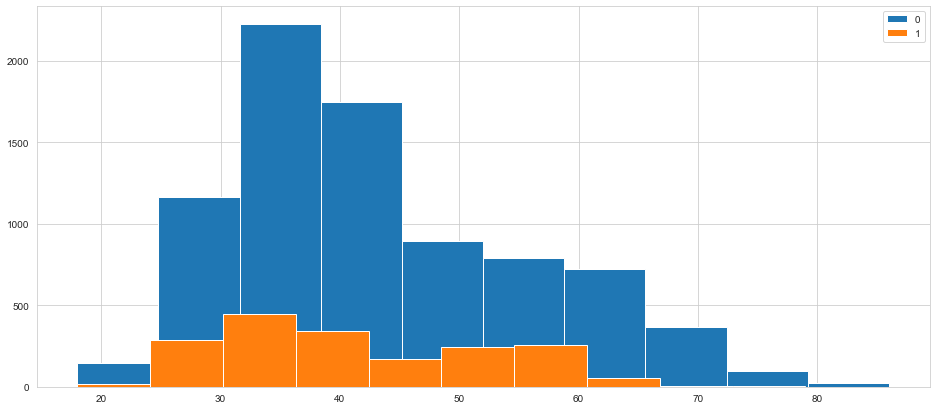

In [705]:
df.groupby('churn')['age'].hist(figsize=(16, 7), legend=True)

Вывод: пользователей можно разделить на следующие сегменты по возрасту: до 25 лет, от 25 до 31-го, от 31 до 45-ти и свыше 45-ти

churn
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: city, dtype: object

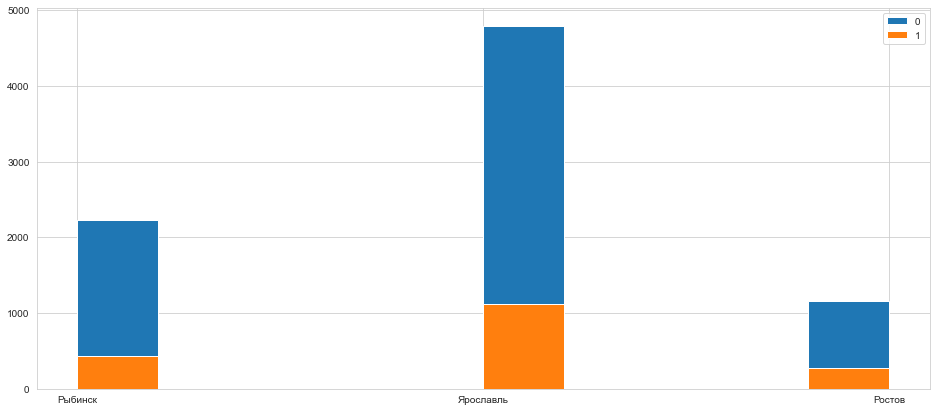

churn
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: city, dtype: object

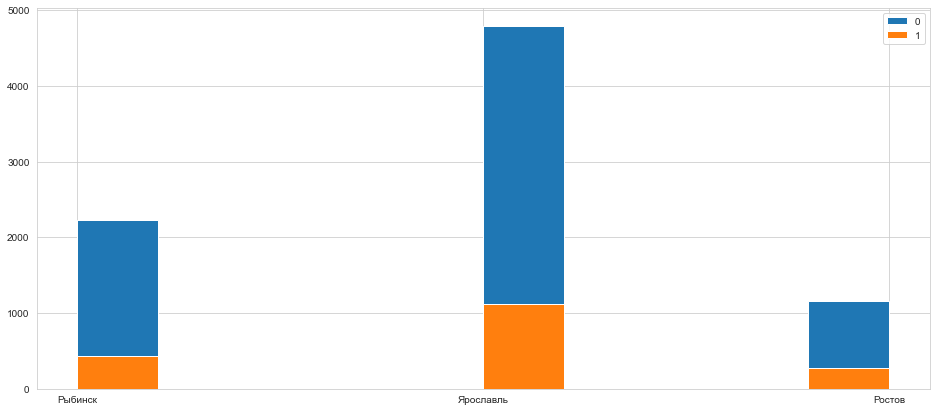

In [706]:
df.groupby('churn')['city'].hist(figsize=(16, 7), legend=True)

Вывод: по городам пользователей можно разделить на три города: Рыбинск, Ярославль и Ростов.

<b>Вывод по разделу:</b>
Пользователей получилось разделить на следующие сегменты:

Географические:
- Рыбинск
- Ярославль
- Ростов

Демографические:
(По возрасту)
- до 25
- до 31
- старше 31-го до 45
- старше 45-ти

(По полу)
- мужчины
- женщины

Потребительские мотивы:
(кредитный рейтинг)
- до 850
- от 850 до 920
- 920 и выше

(кол-во объектов в собственности)
- до 3-х объектов
- от 3-х до 5-ти объектов
- свыше 5-ти

Поведенческий:
(кол-во банковских продуктов)
- один продукт
- два продукта
- три и более продуктов.

<b>Сегменты пользователей влияющих на отток:</b>
- клиенты из Ярославля
- клиенты от 31 до 45
- мужчины
- имеют кредитный рейтинг от 850 до 920
- от 3-х до 5-ти объектов в собвственности
- с двумя банковскими продуктами





## Шаг 8. Выводы и рекомендации (конкретные, по конкретным сегментам) для заказчика

По работе можно сделать следующие выводы:

В ходе исследования подтвердились следующие <b>гипотезы</b>:
- нет различия дохода между клиентами, которые ушли и клиентами которые остались
- нет различия кол-ва баллов кредитного score между клиентами которые ушли и клиентами которые остались

и получились следующие <b>портреты клиентов</b>:

<b>Клиенты склонные к оттоку:</b>
- являются пользователями больше 3-х банковских продуктов
- если имеют объекты в собственности
- являются активными пользователями банка
- чаще всего являются мужчинами
- не имеют кредитных карт
- возраст до 31 года
- имеют большие суммы на балансе счета.

<b>Клиенты не склонные к оттоку:</b>
- пользуются одним банковским продуктом
- не имеют объекты недвижимости в собственности
- не являются активными пользователями банковских услуг
- чаще всего являются женщинами
- имеют кредитные карты
- старше 31-го года
- имеют малые суммы на счетах банка.

Пользователей получилось разделить на следующие <b>сегменты</b>:

Географические:
- Рыбинск
- Ярославль
- Ростов

Демографические:
(По возрасту)
- до 25
- до 31
- старше 31-го до 45
- старше 45-ти

(По полу)
- мужчины
- женщины

Потребительские мотивы:
(кредитный рейтинг)
- до 850
- от 850 до 920
- 920 и выше

(кол-во объектов в собственности)
- до 3-х объектов
- от 3-х до 5-ти объектов
- свыше 5-ти

Поведенческий:
(кол-во банковских продуктов)
- один продукт
- два продукта
- три и более продуктов.

<b>Сегменты пользователей влияющих на отток:</b>
- клиенты из Ярославля
- клиенты от 31 до 45
- мужчины
- имеют кредитный рейтинг от 850 до 920
- от 3-х до 5-ти объектов в собвственности
- с двумя банковскими продуктами

<b>Общие рекомендации по сегментам:</b>
- по городам стоит обратить внимание на Ярославвль т.к. и посмотреть с чем связан отток клиентов в этом городе. В общем ситуация по городам одинаковая и зависит больше от кол-ва клиентов в этом городе. В процентном сообнощении он примерно одинаков.
- основными пользователями услуг банка являются клиенты в возрасте от 31 до 45 лет
- уходят в основном мужчины
- клиенты которые уходят имеют преимущественно большой кредитный рейтинг
- в собственности у клиентов от 3-х до 5-ти объектов недвижимости
- пользуются двумя банковскими продуктами.

Из всего выше сказанного можно сделать вывод, что отточными клиентами являются люди среднего возраста с достатком. В то же время остаются чаще всего люди с кредитами и не имеющих в собственности объектов и больших сумм на счете. Стоит понять в связи с чем связан отток данных клиентов.